In [2]:
import os
import polars as pl
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
# fix and align schemas
cwd = os.getcwd()
dfs = []
for file in os.listdir(cwd):
    if '.xlsx' in file:
        frame = pl.read_excel(
            file,
            schema_overrides={
                'HORA ':pl.String,
                'KILOMETRO ':pl.Float64
            }
        )
        frame = frame.rename(mapping={'TIPO DE VIA':'TIPO DE LA VIA'}, strict=False)
        dfs.append(frame)
df = pl.concat(dfs).lazy()


In [41]:
q = (
    df
    .unpivot(
        on=[
            'MEDIO DE TRANSPORTE DE LA VICTIMA ',
            'Peatón Atrop. por:',
            'Colisión con: '
        ],
        index=['TOTAL '],
        variable_name='Involucrados',
        value_name='Tipo de vehiculo'
        
    )
    .with_columns(
        pl.col('Involucrados').replace({
            'MEDIO DE TRANSPORTE DE LA VICTIMA ':'Victima',
            'Peatón Atrop. por:':'Peaton',
            'Colisión con: ':'Causante'
        })
    )
    # excluir cuando no hay vehiculo reportado
    .filter(~pl.col('Tipo de vehiculo').is_null())
    .group_by(
        pl.col('Tipo de vehiculo'),
        pl.col('Involucrados')
    )
    .agg(
        pl.col('TOTAL ').sum().alias('Accidentes')
    )
    .with_columns(
        pl
        .col('Accidentes')
        .sum()
        .over(partition_by='Tipo de vehiculo')
        .alias('Total Por Tipo de Vehiculo'),
        (pl
        .col('Accidentes')
        .sum()
        .over(partition_by='Tipo de vehiculo') /
        pl
        .col('Accidentes')
        .sum())
        .alias('Total Por Tipo de Vehiculo %')
    )
    .with_columns(
        (pl.col('Accidentes') / pl.col('Total Por Tipo de Vehiculo')).alias('Accidentes %')
    )
    .sort(
        by=['Total Por Tipo de Vehiculo'],
        descending=True
    )
    .collect()
)

In [42]:
q

Tipo de vehiculo,Involucrados,Accidentes,Total Por Tipo de Vehiculo,Total Por Tipo de Vehiculo %,Accidentes %
str,str,i64,i64,f64,f64
"""MOTOCICLETA""","""Victima""",724,867,0.468395,0.835063
"""MOTOCICLETA""","""Causante""",114,867,0.468395,0.131488
"""MOTOCICLETA""","""Peaton""",29,867,0.468395,0.033449
"""CARRO""","""Causante""",101,196,0.105889,0.515306
"""CARRO""","""Peaton""",16,196,0.105889,0.081633
…,…,…,…,…,…
"""LOCOMOTORA""","""Peaton""",1,1,0.00054,1.0
"""MOTOCICLETA DE ALTO CILINDRAJE""","""Causante""",1,1,0.00054,1.0
"""PATANA""","""Causante""",1,1,0.00054,1.0


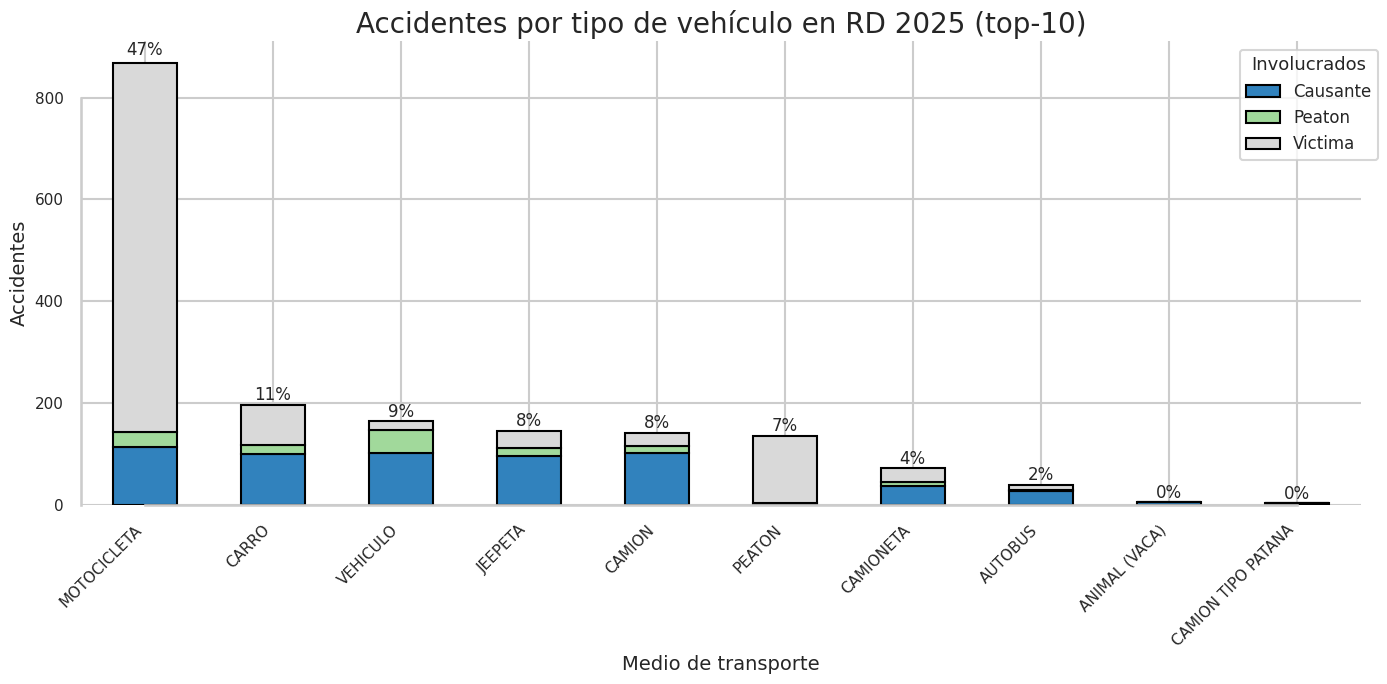

In [45]:
# nicer theme & larger fonts
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.size": 12,
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 12,
    "legend.title_fontsize": 13,
})

# turning to pandas for easier plotting
df_plot = q.to_pandas()

# build a wide table ordered by the total accidents per vehicle type
order = (
    df_plot
    .sort_values('Total Por Tipo de Vehiculo', ascending=False)
    ['Tipo de vehiculo']
    .unique()[:10]
)

wide = (
    df_plot
    .pivot(index='Tipo de vehiculo', columns='Involucrados', values='Accidentes')
    .reindex(order)
)

# plot as a stacked bar chart
ax = wide.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 7),
    colormap='tab20c',
    edgecolor='black'
)
plt.ylabel('Accidentes')
plt.xlabel('Medio de transporte')
plt.title('Accidentes por tipo de vehículo en RD 2025 (top‑10)', fontdict={'size':20})
plt.xticks(rotation=45, ha='right')
plt.legend(title='Involucrados',
           bbox_to_anchor=(1.02, 1),
           loc='best',
           frameon=True)

# mapping from vehicle type to its total‑% value
totals_map = (
    df_plot[['Tipo de vehiculo','Total Por Tipo de Vehiculo %']]
    .drop_duplicates()
    .set_index('Tipo de vehiculo')['Total Por Tipo de Vehiculo %']
    .to_dict()
)

# annotate the top of each bar with the percentage
for i, veh in enumerate(order):
    perc = totals_map.get(veh, 0)
    height = wide.loc[veh].sum()
    ax.text(i, height + height * 0.01, f"{perc:.0%}",
            ha='center', va='bottom')

sns.despine(trim=True)
plt.tight_layout()